In [32]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model, model_from_json
import os

keras.__version__

'2.2.4'

In [2]:
import h5py
import numpy as np
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

In [3]:
arrays = {}
f = h5py.File('MNIST_Autocorrelation.mat')

In [4]:
print(list(f.keys()))

for k, v in f.items():
    arrays[k] = np.array(v)

[u'TestData', u'TestLabels', u'TrainData', u'TrainLabels']


In [5]:
X_train = arrays['TrainData']
y_train = arrays['TrainLabels'].squeeze()
X_test = arrays['TestData']
y_test = arrays['TestLabels'].squeeze()

NUM_CLASSES = 10
NUM_TRAIN_IMAGES = 10000

In [6]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
#X_train = X_train[:,:,0:NUM_TRAIN_IMAGES]
X_train = X_train.transpose(2, 0, 1)
X_train = X_train/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
print(X_train.shape)

(60000, 56, 56, 1)


In [7]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
X_test = X_test.transpose(2, 0, 1)
X_test = X_test/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
print(X_test.shape)

(10000, 56, 56, 1)


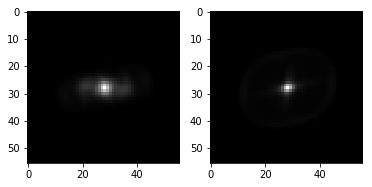

In [8]:
plt.subplot(1,2,1)
plt.imshow(X_train[10].squeeze(),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[10].squeeze(),cmap='gray')
plt.show()

In [9]:
# and one hot encoding the output values
#y_train = y_train[0:NUM_TRAIN_IMAGES]

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(60000, 10)
(10000, 10)


In [10]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis].astype(np.float16)
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [40]:
%%time
try:
    print("started model load")
    with open('model.json', 'r') as file:
        loaded_model_json = file.read()
    resnet = model_from_json(loaded_model_json)
    # load weights into new model
    resnet.load_weights("model.h5")
    resnet.summary()
except Exception as e:
# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
    from keras.layers.normalization import BatchNormalization
    from keras.layers import Add
    from keras.layers import average, concatenate
    from keras.models import Input, Model
    from keras.regularizers import l2 
    l2_lambda = 0.0001

    input_holder = Input(shape=(img_wh, img_wh, 1))

    # start with a conv layer
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(input_holder)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x_split)

    x = Conv2D(filters=64,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    # now add back in the split layer, x_split (residual added in)
    x = Add()([x, x_split])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES)(x)
    x = Activation('softmax')(x)

    resnet = Model(inputs=input_holder,outputs=x)

    resnet.summary()

started model load
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 28, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        max_pooling2d_1[0][0]            
__________________________________________________________________________________________

In [41]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [42]:
history = resnet.fit(X_train, y_train_ohe, batch_size=256, 
                      epochs=20, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.2310 - acc: 0.9396 - val_loss: 0.1869 - val_acc: 0.9529
Epoch 2/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.2282 - acc: 0.9403 - val_loss: 0.1843 - val_acc: 0.9556
Epoch 3/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2227 - acc: 0.9417 - val_loss: 0.1814 - val_acc: 0.9563
Epoch 4/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2230 - acc: 0.9414 - val_loss: 0.1879 - val_acc: 0.9521
Epoch 5/20
60000/60000 [==============================] - 6s 106us/step - loss: 0.2202 - acc: 0.9415 - val_loss: 0.1888 - val_acc: 0.9540
Epoch 6/20
60000/60000 [==============================] - 6s 106us/step - loss: 0.2182 - acc: 0.9424 - val_loss: 0.1817 - val_acc: 0.9553
Epoch 7/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.2181 - acc: 0.9427 - val_loss: 0.1784 - 

In [43]:
model_json = resnet.to_json()
with open("model.json", 'w+') as json_file:
    json_file.write(model_json)
resnet.save_weights("model.h5")
print("Weights Saved to Disk")

Weights Saved to Disk


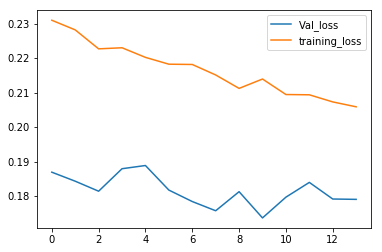

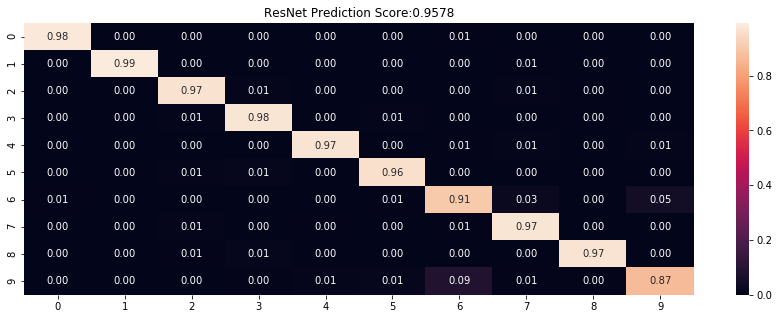

In [44]:
plt.plot(history.history['val_loss'], label="Val_loss")
plt.plot(history.history['loss'], label="training_loss")
plt.legend()

summarize_net(resnet, X_test, y_test, title_text='ResNet Prediction Score:')